# Wearable Computing
October 21, 2015

## A Dato GraphLab Exercise
 <b>Author: Matthew Bird <br />
 AccelOne Data Services Consultant <br /></b>
[accelonedataservices.com][df1] 
[df1]: <http://accelonedataservices.com>

<img src="./AccelOne-logo.png" align="left">


##Resources: 

- [Presentation from SBiA][df1]

- [CSV data file][df2]
[df1]: <http://groupware.les.inf.puc-rio.br/public/2012.SBIA.Ugulino.WearableComputing-Presentation.pdf>
[df2]: <http://groupware.les.inf.puc-rio.br/static/har/dataset-har-PUC-Rio-ugulino.zip>

##Problem Statement:

The overriding design goal for this project is to use the Dato GraphLab framework to produce a machine learning classifier capable of identifying human kinetic behavior from sensors attached to a person. The above mentioned Presentation and Data will be used for the purpose of this Notebook.

##Dataset Description
Data was collected from four subjects.  The subjects were attached with four accelerometers mounted on their waist, left thigh, right arm, and right ankle. They were asked to perform various activities such as sitting, sitting down, standing, standing up, and walking. In addition to the 12 features collected from the accelerometers (x, y, and z components from the four accelerometers derived from a time window of 150ms), the subjects' gender, age, height, weight, and body mass index were also included.  165,633 samples were collected. 


<img src="./WearableDevice.png">

## Outline:
<ol>
<li>Load and Explore dataset</li>
<li>Transform dataset into usable format</li>
<li>Visualize data using Dato GraphLab</li>
<li>Generate preliminary models using Dato GraphLab</li>
<li>Feature Engineering</li>
<li>Generate and tune a final model</li>
<li>Examine Feature Space</li>
<li>Conclusion</li>
</ol>



##1. Load and Explore dataset:

####Imports

In [57]:
import graphlab as gl
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
gl.canvas.set_target('ipynb')
gl.canvas.set_target('browser')

####Load Data

In [58]:
file_path = 'dataset-har-PUC-Rio-ugulino.csv'

In [59]:
df = pd.read_csv (file_path, delimiter =";")

##2. Transform dataset into usable format:

####Function for transforming data
  - Remove single bad data point
  - Converts data to useable types
  - Convert metric commas into decimals

In [60]:
def transform_data(data_frame):
    """
    Accepts a DataFrame object
    Returns modified DataFrame object
    """
    data_frame = data_frame.drop(data_frame.index[[122076]]) #bad data point needs removal
    for col in ['user', 'gender', 'class']:
        data_frame[col] = data_frame[col].astype(str)
    for col in ['age', 'weight', 'x1', 'x2', 'x3', 'x4', 'y1', 'y2', 'y3', 'y4', 'z1', 'z2', 'z3', 'z4']:
        data_frame[col] = data_frame[col].astype(int)
    for col in ['how_tall_in_meters', 'body_mass_index']:
        data_frame[col] = data_frame[col].apply(lambda x: str(x).replace(".","").replace(",","."))
        data_frame[col] = data_frame[col].astype(float)
    return data_frame

In [61]:
df = transform_data(df)
sf = gl.SFrame(data = df)


##3. Visualize data using Dato GraphLab:

 ####Using GraphLab Visualization we can see that our data includes 18 features
  - **5 User metrics** (Name, Gender, Age, Height, BMI)  
  - **12 sensor readings** (x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
  - **1 Class** - Prediction target - (sitting, standing, walking, standingup, sittingdown)

In [62]:
sf.show() # Show the full dataset in Graphlab Canvas in its own browser tab 
sf.head()

Canvas is accessible via web browser at the URL: http://localhost:57160/index.html
Opening Canvas in default web browser.


user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3
debora,Woman,46,1.62,75,28.6,-3,92,-63,-23,18,-19,5,104
debora,Woman,46,1.62,75,28.6,-3,94,-64,-21,18,-18,-14,104
debora,Woman,46,1.62,75,28.6,-1,97,-61,-12,20,-15,-13,104
debora,Woman,46,1.62,75,28.6,-2,96,-57,-15,21,-16,-13,104
debora,Woman,46,1.62,75,28.6,-1,96,-61,-13,20,-15,-13,104
debora,Woman,46,1.62,75,28.6,-2,95,-62,-14,19,-16,-13,104
debora,Woman,46,1.62,75,28.6,1,100,-62,-10,22,-12,-13,104
debora,Woman,46,1.62,75,28.6,-1,97,-63,-13,20,-15,-12,104
debora,Woman,46,1.62,75,28.6,-1,98,-63,-14,19,-17,-13,104
debora,Woman,46,1.62,75,28.6,0,98,-61,-11,22,-13,-13,104


#### Show Breakdown of Activity Categories

In [63]:
gl.canvas.set_target('ipynb')
sf['class'].show(view='Categorical')

Majority class prediction is ~30.57%  This is the accuracy we can get with guessing and provides a baseline that we want to improve on.

##4. Generate preliminary models using Dato GraphLab:

####Run the GraphLab general classifier to discover the method with the highest accuracy.

In [64]:
model = gl.classifier.create(sf, target='class')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.
PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 157193
PROGRESS: Number of classes           : 5
PROGRESS: Number of feature columns   : 18
PROGRESS: Number of unpacked features : 18
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.371e-01   9.390e-01        0.89s
PROGRESS:      1   9.462e-01   9.506e-01        1.84s
PROGRESS:      2   9.

 ####The GraphLab general classifier discovers that GradientBoostedTrees look promising with the highest accuracy of 97%
  - BoostedTreesClassifier          : **~0.97**
  - RandomForestClassifier          : ~0.94
  - LogisticClassifier              : ~0.83
  

We can go on to show that the model only uses 10 or so of features for the majority of its classification.  Features like age, gender, and BMI show little utility and land to the right-hand side of the following graph

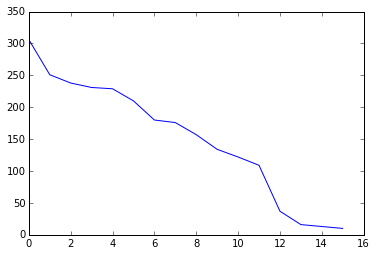

In [65]:
i_feats = model.get_feature_importance()
f_imps = i_feats['count']
plt.plot(f_imps)

In [66]:
i_feats.print_rows(20) #gender not shown, but in test trials it was dead-last in importance

+--------------------+-------+
|      feature       | count |
+--------------------+-------+
|         y3         |  306  |
|         z1         |  251  |
|         y2         |  238  |
|         z2         |  231  |
|         z3         |  229  |
|         x4         |  210  |
|         x3         |  180  |
|         z4         |  176  |
|         x2         |  157  |
|         y1         |  134  |
|         y4         |  122  |
|         x1         |  109  |
|        age         |   37  |
|       weight       |   16  |
|  body_mass_index   |   13  |
| how_tall_in_meters |   10  |
+--------------------+-------+
[16 rows x 2 columns]



##5. Feature Engineering:

####First we convert non-numeric values into unique integers for Machine Learning friendliness
####Next we consider that the acceleromer readings belong to 4 different sensors
    - Sensor 1: x1, y2, z1
    - Sensor 2: x2, y2, z2
    - Sensor 3: x3, y3, z3
    - Sensor 4: x4, y4, z4
    
####We can calculate the latent features of Yaw and Pitch for each sensor using the following formulas
    
    - **Pitch, P =** atan( x / sqrt( y^2 + z^2 ) )
    - **Yaw, Y =** atan( y / sqrt( x^2 + z^2 ) )
    
Source: [Freescale Semiconductor Document Number: AN3461 Application Note Rev. 6, 03/2013][df1]


####Additionally the difference of Pitch and Roll between the devices has utility as they are mounted on different locations across the person wearing them. The relative difference between Yaw for sitting vs. standing for instance will be markedly different.
    
    - **n1n2PitchDiff =** Pitch_n1 - Pitch_n2 (for all devices n1 and n2 where n1 is not n2)
    - **n1n2RollDiff =** Roll_n1 - Roll_n2 (for all devices n1 and n2 where n1 is not n2)

####Finally we perform Principal Component Analysis(PCA) to remove any co-linearity, and reduce the feature space down to a managable number of significant features

[df1]: <https://cache.freescale.com/files/sensors/doc/app_note/AN3461.pdf>

In [67]:
def convert_columns_to_unique_ints(data_frame):
    '''
    Accepts DataFrame object
    Returns DataFrame where non-numeric values are given numeric values
    '''
    for col_name in ['user', 'gender', 'class']:
        original_values = data_frame[col_name].unique()
        new_values = range(len(original_values))
        print "converting", original_values
        print "into......", new_values
        data_frame[col_name] = data_frame[col_name].replace(original_values, new_values)
    return data_frame

def pitch(x,y,z):
    """
    Accepts accelerometer readings from a device and 
    Returns pitch angle
    """
    return math.atan( x / math.sqrt( y**2 + z**2 ) )

def roll(x,y,z):
    """
    Accepts accelerometer readings from a device and 
    Returns roll angle
    """
    return math.atan( y / math.sqrt( x**2 + z**2 ) )

def add_pitch_roll(data_frame):
    """
    Accepts DataFrame 
    Returns DataFrame with new columns for orientation angles
    """
    result = data_frame.copy()
    for i in range(1,5):
        s = str(i)
        result['pitch'+s] = np.vectorize(pitch)(result['x'+s], result['y'+s], result['z'+s])
        result['roll'+s] = np.vectorize(roll)(result['x'+s], result['y'+s], result['z'+s])
    return result

def add_pitch_roll_diff(data_frame):
    """
    Accepts DataFrame
    Returns DataFrame with new columns for difference between orientation angles
    """
    result = data_frame.copy()
    for i in range(1,5):
        for j in range(1,5):
            s1, s2 = str(i), str(j)
            if s1 != s2:
                result['pitchdiff'+s1+s2] = np.vectorize(np.subtract)(result['pitch'+s1], result['pitch'+s2])
                result['rolldiff'+s1+s2] = np.vectorize(np.subtract)(result['roll'+s1], result['roll'+s2])
    return result

def PCAIT(data_frame, n_features):
    """
    Accepts DataFrame
    Returns DataFrame which as been PCA reduced down to n_features
    """
    result = data_frame.copy()
    target = result.pop('class')
    pca = PCA(n_components = n_features)
    pca.fit(result)
    result = pd.DataFrame(pca.transform(result))
    result['class'] = target.astype(str)
    return result

 ####Perform the conversion

In [68]:
df = convert_columns_to_unique_ints(df) # convert columns with names into integer values
df = add_pitch_roll(df)
df = add_pitch_roll_diff(df)
df_non_PCA = df.copy() # ignore this for now, we will use it on step 7
df = PCAIT(df, n_features = 25) # 25 features are chosen because additional features showed diminishing returns

converting ['debora' 'katia' 'wallace' 'jose_carlos']
into...... [0, 1, 2, 3]
converting ['Woman' 'Man']
into...... [0, 1]
converting ['sitting' 'sittingdown' 'standing' 'standingup' 'walking']
into...... [0, 1, 2, 3, 4]


####Normalize the data and ensure the target is of type int

In [69]:
def normalize(df, target):
    """
    Accepts DataFrame object and a target column
    Returns DataFrame with normalized columns (target is not normalized)
    """
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != target:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [70]:
df = normalize(df, 'class' )
df['class'] = df['class'].astype(float).fillna(0).astype(int)
sf = gl.SFrame(data = df)   #turn DataFrame into GraphLab SFrame object

In [71]:
sf.head()

0,1,2,3,4,5,6
0.219918343408,0.370460285945,0.777746408514,0.350440671269,0.384048585486,0.755494393487,0.33440179476
0.218518236848,0.374019807763,0.770247656003,0.337790471089,0.380739945825,0.759364919324,0.334375176262
0.212074060837,0.373639880772,0.770651302865,0.338145826872,0.377539995259,0.75528598348,0.335189450462
0.213331408163,0.373114653493,0.771120501631,0.337816795687,0.373323446835,0.751652114496,0.334972289486
0.212530097708,0.373042307564,0.770536936217,0.337848476514,0.377900666917,0.752170048975,0.334546871336
0.213988309974,0.372944563878,0.770325991609,0.337919402197,0.378607179634,0.752197089803,0.334671566416
0.208687096485,0.373448764338,0.770296487723,0.337786237743,0.380858177654,0.756243239734,0.333908088346
0.212496000809,0.372357588721,0.771108957788,0.3381063197,0.380072307311,0.755414760974,0.332849592304
0.214488424331,0.372375533864,0.769348931748,0.338344290242,0.379902315835,0.755190343388,0.334403864677
0.209614916044,0.373563250822,0.770582804797,0.338036450154,0.378472087878,0.75564290529,0.334706686888


##6. Generate and tune model:

####Next we generate a new GradientBoostedTrees classifier using our engineered features and tune the following parameters using a grid_search to maximize accuracy:
   - max_iterations
   - max_depth
   - step_size
   - column_subsample
   - row_subsample

In [81]:
train, test = sf.random_split(.9)  #randomly choose 10% of the data and set aside for model verification
model = gl.boosted_trees_classifier.create(train, target='class', column_subsample=.55, max_depth=9, 
                                           max_iterations=170, min_child_weight=8, min_loss_reduction=0,
                                           row_subsample=.85, step_size=.3)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: WARNING: Detected extremely low variance for feature(s) 'predicted_class' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.
PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 141401
PROGRESS: Number of classes           : 5
PROGRESS: Number of feature columns   : 26
PROGRESS: Number of unpacked features : 26
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.551e-01   9.495e-01        1.59s
PROG

####Finally we inspect our new model and see that the accuracy of our classification has risen to ~99.65%
  

####We can go on to show that this model uses more of its feature space than the default model

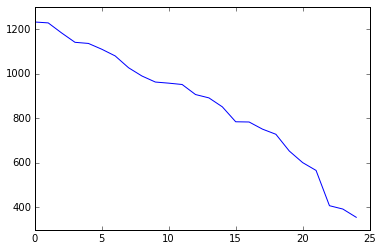

In [73]:
i_feats = model.get_feature_importance()
f_imps = i_feats['count']
plt.plot(f_imps)

In [75]:
i_feats.print_rows(18)

+---------+-------+
| feature | count |
+---------+-------+
|    11   |  1231 |
|    5    |  1227 |
|    6    |  1182 |
|    1    |  1140 |
|    24   |  1135 |
|    3    |  1109 |
|    4    |  1079 |
|    0    |  1026 |
|    9    |  989  |
|    15   |  962  |
|    17   |  957  |
|    7    |  951  |
|    23   |  906  |
|    2    |  891  |
|    14   |  851  |
|    12   |  784  |
|    13   |  783  |
|    10   |  751  |
+---------+-------+
[25 rows x 2 columns]



####Since PCA precludes interpretability of the features, we can run the experiment again without PCA just to see what features are important and gain a little insight into our model

##7. Examine Feature Space:

####Using the df_non_PCA we set aside from step 5, let's see what features were important

In [76]:
df_non_PCA = normalize(df_non_PCA, 'class' )
df_non_PCA['class'] = df_non_PCA['class'].astype(float).fillna(0).astype(int)
sf_non_PCA = gl.SFrame(data = df_non_PCA)   #turn DataFrame into GraphLab SFrame object

In [77]:
model_non_PCA = gl.classifier.create(sf_non_PCA, target='class')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.
PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 157365
PROGRESS: Number of classes           : 5
PROGRESS: Number of feature columns   : 50
PROGRESS: Number of unpacked features : 50
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.403e-01   9.364e-01        3.44s
PROGRESS:      1   9.542e-01   9.483e-01        6.98s
PROGRESS:      2   9.

####Print most significant features

In [78]:
i_feats = model_non_PCA.get_feature_importance()
f_imps = i_feats['count']
i_feats.print_rows(25)

+------------+-------+
|  feature   | count |
+------------+-------+
|     y3     |  212  |
|     y2     |  153  |
|     z2     |  143  |
|     z1     |  127  |
|     z3     |  113  |
|     z4     |  112  |
|     y1     |   96  |
|     x4     |   81  |
|     x2     |   74  |
|   roll3    |   72  |
|   roll2    |   67  |
|   roll4    |   64  |
|   pitch4   |   62  |
|   pitch3   |   58  |
|     x1     |   48  |
|    age     |   47  |
|     y4     |   47  |
|    user    |   47  |
|   pitch2   |   46  |
|   roll1    |   43  |
|   pitch1   |   42  |
|     x3     |   40  |
| rolldiff13 |   37  |
| rolldiff42 |   34  |
| rolldiff23 |   33  |
+------------+-------+
[50 rows x 2 columns]



#8. Conclusion:
- ####Engineering Features Roll/Pitch took us from ~96% to ~98% accuracy (Step 5)
- ####PCA took us from ~98% to ~99.6% accuracy (Step 6)
- ####Roll/Pitch-Difference seem to be less significant but was still useful



### Comparison to the Ugulino (2012) Results

The best accuracy achieved above was ~99.6%.  The best accuracy achieved with [Ugulino (2012)][df1] was ~99.4%.  Dato Graphlab was able to achieve a 0.2% improvement over Ugulino (2012).

Here is the confusion matrix based on the results from Ugulino (2012). 

[df1]: <http://groupware.les.inf.puc-rio.br/public/papers/2012.Ugulino.WearableComputing.HAR.Classifier.RIBBON.pdf>



<img align="left" src="./UgulinoConfusionMatrix2.png">

And for comparison sake, below is the confusion matrix using the model that achieved the highest accuracy (~99.6%).

In [84]:
label = {0:'Sitting', 1:'Sitting down', 2:'Standing', 3:'Standing up', 4:'Walking'}

sf['predicted_class'] = model.predict(sf)
gl.evaluation.confusion_matrix(sf['class'].apply(lambda x: label[x]), sf['predicted_class'].apply(lambda x: label[x])).print_rows(num_rows=20)


+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|   Standing   |     Walking     |   13  |
|   Walking    |     Sitting     |   1   |
|   Walking    |   Standing up   |   2   |
|   Walking    |     Standing    |   11  |
| Standing up  |   Standing up   | 12381 |
|   Walking    |     Walking     | 43371 |
| Standing up  |     Standing    |   11  |
| Standing up  |   Sitting down  |   16  |
|   Standing   |   Sitting down  |   1   |
|   Sitting    |   Standing up   |   2   |
| Sitting down |     Standing    |   2   |
| Sitting down |     Walking     |   2   |
| Sitting down |   Sitting down  | 11813 |
|   Walking    |   Sitting down  |   4   |
| Sitting down |     Sitting     |   2   |
| Standing up  |     Walking     |   2   |
| Sitting down |   Standing up   |   8   |
|   Standing   |     Standing    | 47353 |
|   Standing   |   Standing up   |   3   |
|   Sitting    |     Sitting     | 50630 |
+----------